# Cardiovascular Disease Prediction
Classification goal: predict 10-year risk of coronary heart disease (CHD).

Data: sourced from Kaggle. It is from an ongoing cardiovascular study on residents of the town of Framingham, Massachusetts. It includes 3,390 records, 15 attributes (risk factors), and the target variable—CHD morbidity.

Variables:
Each attribute is a potential risk factor: demographic, behavioral, or medical.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression  
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay, precision_recall_curve, f1_score, average_precision_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import numpy as np
df = pd.read_csv("train.csv", index_col=0)
print(df.shape) # (rows, columns)
df.sample(5)

(3390, 16)


,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,,,,,,
1399,39,3.0,F,YES,8.0,0.0,0,0,0,192.0,109.0,61.0,23.36,64.0,84.0,0
2951,52,1.0,M,NO,0.0,0.0,0,0,0,266.0,107.0,75.0,25.64,82.0,98.0,0
2434,62,1.0,M,YES,30.0,0.0,0,0,0,373.0,138.5,85.0,23.35,80.0,67.0,0
2895,38,2.0,F,YES,12.0,0.0,0,0,0,209.0,122.5,76.5,24.51,90.0,73.0,0
353,56,NaN,F,YES,5.0,0.0,0,0,0,285.0,124.0,80.0,24.54,52.0,106.0,0


## Logistic Regression Model

CV ROC-AUC: 0.724 ± 0.014
CV PR-AUC : 0.350 ± 0.021
CV Recall : 0.658 ± 0.041

Confusion Matrix:
 [[438 138]
 [ 38  64]]

Classification Report:
               precision    recall  f1-score   support

           0      0.920     0.760     0.833       576
           1      0.317     0.627     0.421       102

    accuracy                          0.740       678
   macro avg      0.618     0.694     0.627       678
weighted avg      0.829     0.740     0.771       678

ROC AUC: 0.7215754357298475
PR  AUC: 0.3257254401259274


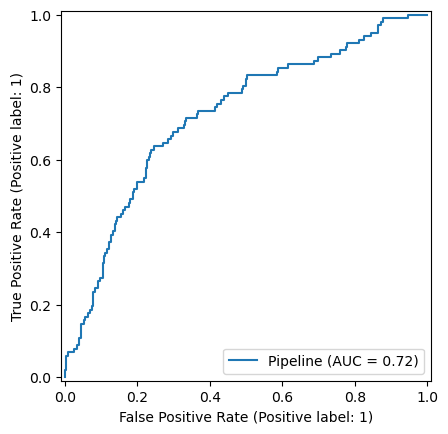

In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, RocCurveDisplay, average_precision_score
)

y = df["TenYearCHD"]
X = df.drop(columns=["TenYearCHD", "prevalentHyp", "is_smoking", "diabetes"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#2) Define columns

num_cols = [c for c in [
    "age","cigsPerDay","totChol","sysBP","diaBP","BMI","heartRate","glucose"
] if c in X.columns]

cat_cols = [c for c in ["sex","BPMeds","education"] if c in X.columns]


# 3) Preprocessing pipelines (fit on TRAIN only)
numeric_pipe = Pipeline(steps=[
    ("impute", IterativeImputer(random_state=42)),
    ("scale",  RobustScaler())
])

categorical_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe",    OneHotEncoder(drop="if_binary", handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

# 4) Full model pipeline
clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# 5) Cross-validation on TRAIN ONLY
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_roc = cross_val_score(clf, X_train, y_train, cv=cv, scoring="roc_auc")
cv_pr  = cross_val_score(clf, X_train, y_train, cv=cv, scoring="average_precision")
cv_rec = cross_val_score(clf, X_train, y_train, cv=cv, scoring="recall")

print(f"CV ROC-AUC: {cv_roc.mean():.3f} ± {cv_roc.std():.3f}")
print(f"CV PR-AUC : {cv_pr.mean():.3f} ± {cv_pr.std():.3f}")
print(f"CV Recall : {cv_rec.mean():.3f} ± {cv_rec.std():.3f}")


# 6) Fit on TRAIN, evaluate on TEST
clf.fit(X_train, y_train)

y_proba = clf.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= 0.53).astype(int)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("PR  AUC:", average_precision_score(y_test, y_proba))

RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.show()